In [1]:
import pandas as pd
import numpy as np
import os, glob
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm, ticker
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

def getinfo(place, year, stage):
    df = pd.read_csv('../DataBase/Experiment_period.txt')
    df_ = df[df['region']==place][df['year']==year][df['index']==stage]
    begintime = pd.to_datetime(df_['begin'].values[0])
    endtime = pd.to_datetime(df_['end'].values[0])
    month = str(begintime.month).zfill(2)
    return begintime, endtime, month

In [26]:
place = 'Taoyuan'
year = 2023
stage = 3


savefig = True


if place == 'Taoyuan':
    begintime, endtime, month = getinfo(place, year, stage)
    sunpath = glob.glob(f'../DataBase/Data_CWA/sunset_time_taoyuan{year}.csv')[0]
    lightpath = glob.glob(f'../DataBase/Temperature/Taoyuan/{str(year)[2:4]}{month}*.xlsx')[0] if glob.glob(f'../DataBase/Temperature/Taoyuan/{str(year)[2:4]}{month}*.xlsx') != [] else None
    rainpath = glob.glob(f'/Volumes/Data/Rainfall_CWA/467050_新屋/467050_{year}.csv')[0]
    tidepath = glob.glob(f'../DataBase/Data_CWA/{year}_1116_竹圍_tide.csv')[0]
    # begintime = datetime(year, 6, 27); endtime = datetime(year, 7, 22)
    
    ymin= 0; ymax = 5000 #Taoyuan 04 
    # ymin = 1500; ymax=6000


elif place == 'Keelung':
    begintime, endtime, month = getinfo(place, year, stage)
    sunpath = glob.glob(f'../DataBase/Data_CWA/sunset_time_keelung{year}.csv')[0]
    lightpath = glob.glob(f'../DataBase/Temperature/Keelung/{str(year)[2:4]}{month}*.xlsx')[0] if glob.glob(f'../DataBase/Temperature/Keelung/{str(year)[2:4]}{month}*.xlsx') != [] else None
    if year == 2021:
        rainpath = glob.glob(f'/Volumes/Data/Rainfall_CWA/466940_基隆/466940_{year}.csv')[0]
    else:
        rainpath = glob.glob(f'/Volumes/Data/Rainfall_CWA/C0B050_八斗子/C0B050_{year}.csv')[0]
    tidepath = glob.glob(f'../DataBase/Data_CWA/{year}_12191_長潭里_tide.csv')[0]
    # begintime = datetime(year, 4, 17, 12); endtime = datetime(year, 5, 3, 12)
    ymin=2000; ymax=12000
dsun = pd.read_csv(sunpath)
path = f'/Volumes/home/Research/Detection_snap/{place}/{str(year)[2:4]}{month}*'    
print(begintime, endtime)
print(f'sunpath:   {sunpath}')
print(f'lightpath: {lightpath}')
print(f'rainpath:  {rainpath}')
print(f'tidepath:  {tidepath}')

2023-08-18 11:00:00 2023-09-02 22:00:00
sunpath:   ../DataBase/Data_CWA/sunset_time_taoyuan2023.csv
lightpath: ../DataBase/Temperature/Taoyuan/230818-230915.xlsx
rainpath:  /Volumes/Data/Rainfall_CWA/467050_新屋/467050_2023.csv
tidepath:  ../DataBase/Data_CWA/2023_1116_竹圍_tide.csv


In [27]:
def plotnight(time, ax, ymin, ymax):
    year = time.year
    month = time.month
    day = time.day
    nextdate = time+timedelta(days=1)
    nextyear = nextdate.year
    nextmonth = nextdate.month
    nextday = nextdate.day
    
    if year == 2024:
        sunpath = glob.glob(f'../DataBase/Data_CWA/sunset_time_keelung{year}.csv')[0]
        df = pd.read_csv(sunpath)
    else:
        df = dsun
    sunset_hr = int((df['SUNSET'][df['TIME'] == f'{year}/{month}/{day}'].values[0]).rsplit(':')[-2])    
    sunset_min = int((df['SUNSET'][df['TIME'] == f'{year}/{month}/{day}'].values[0]).rsplit(':')[-1])
    
    if nextyear != year:
        sunpath = glob.glob(f'../DataBase/Data_CWA/sunset_time_keelung{nextyear}.csv')[0]
        df = pd.read_csv(sunpath)
        
    sunrise_hr = int((df['SUNRSET'][df['TIME'] == f'{nextyear}/{nextmonth}/{nextday}'].values[0]).rsplit(':')[-2])
    sunrise_min = int((df['SUNRSET'][df['TIME'] == f'{nextyear}/{nextmonth}/{nextday}'].values[0]).rsplit(':')[-1])
    for i in range(len(ax)):
        ymax = 25000 if i == 0 else ymax
        ymin = 0 if i != 1 else ymin
        ax[i].fill_betweenx(y=[ymin-5, ymax], x1=datetime(year, month, day, sunset_hr, sunset_min), x2=datetime(nextyear, nextmonth, nextday, sunrise_hr, sunrise_min), color='orange', alpha=0.1)
    return ax

def plotlight(time, ax, excess=25000):
    month = str(time.month).zfill(2)
    day = str(time.day).zfill(2)
    filepath = lightpath
    if filepath is not None:
        dlight = pd.read_excel(filepath, header=None, names=['Time', 'Temp', 'Light'], skiprows=110,) 
        dlight = dlight[dlight['Light']<excess]
        dlight_ = dlight[dlight['Time'] <= np.datetime64(f'{year}-{month}-{day} 23:59:59')][dlight['Time'] >= np.datetime64(f'{year}-{month}-{day} 00:00:00')]
        try:
            begintime = pd.to_datetime(str(dlight_['Time'].values[0]))
            endtime   = pd.to_datetime(str(dlight_['Time'].values[-1]))
            ax.plot(pd.to_datetime(dlight_['Time']), dlight_['Light'], 'dimgrey', lw=0.75)
        except:
            pass
        ax.set_ylabel('Illumination (lux)', color='dimgrey', fontsize=fsize)
        ax.set_ylim(0, excess)
        ax.tick_params(axis='y', colors='dimgrey')
    
    return ax

def plotrain(ax, ymin=0, ymax=40):
    # rainpath = rainpath
    drain = pd.read_csv(rainpath)
    ax.plot(pd.to_datetime(drain['time(UTC+8)']), drain['rain_in_hr'], c='dodgerblue', lw=1)
    ax.set_ylabel('Precipitation (mm)', color='dodgerblue', fontsize=fsize)
    ax.tick_params(axis='y', colors='dodgerblue')
    ax.set_ylim(ymin, ymax)
    
    return ax


def readtide():
    def get_strtime(time):
        yyyy = str(time.year)
        mm   = str(time.month).zfill(2)
        dd   = str(time.day).zfill(2)
        hh   = str(time.hour).zfill(2)
        return f'{yyyy}{mm}{dd}{hh}'
    
    # tidepath = tidepath
    dtide_ori = pd.read_csv(tidepath, skiprows=20)
    begin = get_strtime(begintime); end = get_strtime(endtime)
    dtide_ori = dtide_ori[dtide_ori['yyyymmddhh'] >= int(begin)][dtide_ori['yyyymmddhh'] <= int(end)]
    tide = {'time':[], 'height':[], 'diff':[]}
    
    for time in dtide_ori['yyyymmddhh']:
        timestr = str(time)
        yyyy = int(timestr[:4])
        mm  = int(timestr[4:6])
        dd = int(timestr[6:8])
        hh = int(timestr[8:10])
        dtide_temp = dtide_ori[dtide_ori['yyyymmddhh']==time]
        for minn_str in [':00', ':06', ':12', ':18', ':24', ':30', ':36', ':42', ':48', ':54']:
            tideheight = dtide_temp[minn_str].values[0]
            minn = int(minn_str.rsplit(':')[-1])
            tide['time'].append(datetime(yyyy,mm,dd,hh,minn))
            tide['height'].append(tideheight)

    for j in range(len(tide['height'])):
        if j+1 != len(tide['height']):
            h1 = tide['height'][j]
            h2 = tide['height'][j+1]

            diff = (h2 - h1)/(6*60)
            tide['diff'].append(diff)
        else:
            tide['diff'].append(np.nan)
    df = pd.DataFrame(tide)
    return df 

def plottide(ax, time, df, ymin, ymax, height_list):
    def nan_argsort(matrix):
        temp = matrix.copy()
        temp[np.isnan(matrix)] = np.inf
        return temp.argsort()
    def sort_df(df_time):
        df_time = df_time.reset_index(drop=True)
        index_vel = np.where(abs(df_time['diff'])<=0.05)[0] #0.075
        df_time = df_time[df_time.index.isin(index_vel)]
        df_clear = df_time.reset_index(drop=True)

        sorted_height = df_clear['height'][nan_argsort(df_clear['height'])]
        sorted_height_nonan = sorted_height[~np.isnan(sorted_height)]
        return df_clear, sorted_height_nonan
    
    
    year = time.year
    month = time.month
    day = time.day
    for hr in [0, 12]:
        df_ = df[df['time']>=datetime(year, month, day, hr, 0)][df['time']<=datetime(year, month, day, hr+11, 59)]  
        df_clear, sorted_height_nonan = sort_df(df_)
        try:
            min_h_time = [df_clear['time'][i] for i in sorted_height_nonan[:1].index][0]
            max_h_time = [df_clear['time'][i] for i in sorted_height_nonan[-1:].index][0]
            # delta_hr = (pd.to_datetime(max_h_time) - pd.to_datetime(min_h_time)).total_seconds()/60/60
            if len(height_list)>1:
                delta_hr = (pd.to_datetime(max_h_time) - pd.to_datetime(height_list[-1])).total_seconds()/60/60
                if delta_hr >= 5: 
                    ax.vlines(x = pd.to_datetime(max_h_time), ymin=ymin, ymax=ymax, color='purple', linestyle=(0, (5, 5)), linewidth=0.5, alpha=0.4 )
            else:
                ax.vlines(x = pd.to_datetime(max_h_time), ymin=ymin, ymax=ymax, color='purple', linestyle=(0, (5, 5)), linewidth=0.5, alpha=0.4 )
#                     print('qqq', max_height_time[-1], max_h_time)
#                     pre_time = pd.to_datetime(max_height_time[-1])
#                     mm = pre_time.month
#                     dd = pre_time.day
#                     hh = pre_time.hour
#                     df_ = df[df['time']>=datetime(year, mm, dd, hh+3, 0)][df['time']<=datetime(year, mm, dd, hr+7, 59)]  
#                     df_clear, sorted_height_nonan = sort_df(df_)
#                     max_h_time = [df_clear['time'][i] for i in sorted_height_nonan[-1:].index][0]
                
            
            # ax.vlines(x = pd.to_datetime(min_h_time), ymin=0, ymax=10000, color='grey', linestyle='dotted', linewidth=0.5  )
            # print(max_h_time)
            
            height_list.append(pd.to_datetime(max_h_time))
        except:
            pass
    return ax

In [28]:
alldf = pd.DataFrame()

for filepath in sorted(glob.glob(f'{path}/*csv')):

    df = pd.read_csv(filepath)
    alldf= pd.concat([alldf, df])
    
print(np.mean(alldf['Peak']),np.mean(alldf['SPLrms']))

3372.8307919992826 121.43342650642114


/Volumes/home/Research/Detection_snap/Taoyuan/230818-230902/detect_230818.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230818-230902/detect_230819.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230818-230902/detect_230820.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230818-230902/detect_230821.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230818-230902/detect_230822.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230818-230902/detect_230823.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230818-230902/detect_230824.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230818-230902/detect_230825.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230818-230902/detect_230826.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230818-230902/detect_230827.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230818-230902/detect_230828.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230818-230902/detect_230829.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230818-230902/dete

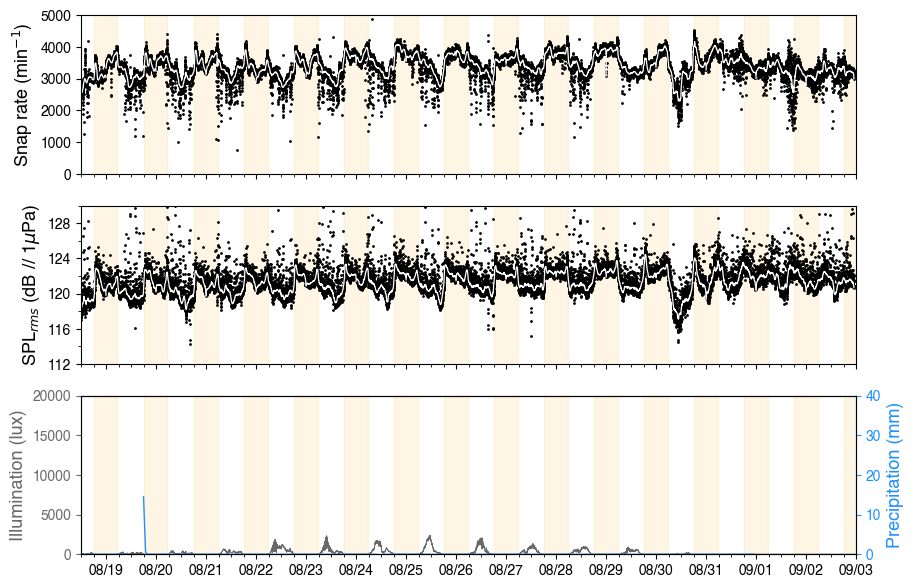

In [32]:
plt.rc('font', family='Helvetica')
fig, ax = plt.subplots(3, figsize=(10, 7), sharex=True)


fsize = 13

#=======================================================
ax_rain = ax[2].twinx()
ax_rain = plotrain(ax_rain)
ax[2].spines['right'].set_color('dodgerblue')
ax[2].spines['left'].set_color('dimgrey')

if lightpath is None:
    ax[2].yaxis.set_major_locator(ticker.NullLocator())
    ax[2].tick_params(left=False)

dtide = readtide()
height_list = [] 
temp = []
for filepath in sorted(glob.glob(f'{path}/*csv')):
    
    df = pd.read_csv(filepath)
    gettime = pd.to_datetime(df['Time'].values[0])
    ax = plotnight(gettime, ax, ymin, ymax)
    ax[2] = plotlight(gettime, ax[2])
    # ax[0] = plottide(ax[0], gettime, dtide, ymin, ymax, height_list)
    # ax[1] = plottide(ax[1], gettime, dtide, 90, 135, temp)
    ax[0].scatter(pd.to_datetime(df['Time']), df['Peak'], c='k', marker='o', s=1 )
    ax[0].plot(pd.to_datetime(df['Time']), signal.medfilt(df['Peak'], 59 ), color = 'white', lw=0.9)
    ax[1].scatter(pd.to_datetime(df['Time']), df['SPLrms'], c='k', marker='o', s=1 )
    ax[1].plot(pd.to_datetime(df['Time']), signal.medfilt(df['SPLrms'], 59 ), color = 'white', lw=0.9)
    print(filepath)
    
light_ymax=20000 # 6000
ax[2].set_ylim(0, light_ymax)
# Timestamp('2023-08-18 11:00:00'), Timestamp('2023-09-02 22:00:00')
# ax[0].set_xlim(begintime, datetime(2023,9,14,12))#endtime
ax[0].set_xlim(datetime(2023,8,18,12), datetime(2023,9,3,0))
ax[0].set_ylim(ymin, ymax)
ax[0].set_ylabel('Snap rate (min$^{-1}$)', fontsize=fsize)
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=1))   #to get a tick every 15 minutes
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))     #optional formatting 
ax[0].xaxis.set_minor_locator(mdates.HourLocator(interval=6))   #to get a tick every 15 minutes


ax[1].set_ylim(112, 130)
ax[1].set_ylabel('SPL$_{rms}$ (dB // 1$\mu$Pa)', fontsize=fsize)
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(4))  
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(2)) 

if savefig:
    print('Saving figure. ')
    savepath = '/Users/tong/Dropbox/海保署報告/Final/Figure/Fig_daily_snap_rate_Keelung'
    plt.savefig(f'{savepath}/{place}_{year}{month}_variations.png', dpi=200, bbox_inches='tight')
    plt.savefig(f'{savepath}/{place}_{year}{month}_variations.pdf', dpi=200)    
    # plt.savefig(f'../Results/Detection_snap/{place}/{place}_{year}{month}_variations.png', dpi=200, bbox_inches='tight')
    # plt.savefig(f'../Results/Detection_snap/{place}/{place}_{year}{month}_variations.pdf', dpi=200)

In [30]:
begintime,endtime

(Timestamp('2023-08-18 11:00:00'), Timestamp('2023-09-02 22:00:00'))


## SPL and Snap relationship

5000
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230414.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230415.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230416.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230417.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230418.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230419.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230420.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230421.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230422.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230423.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230424.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230425.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501

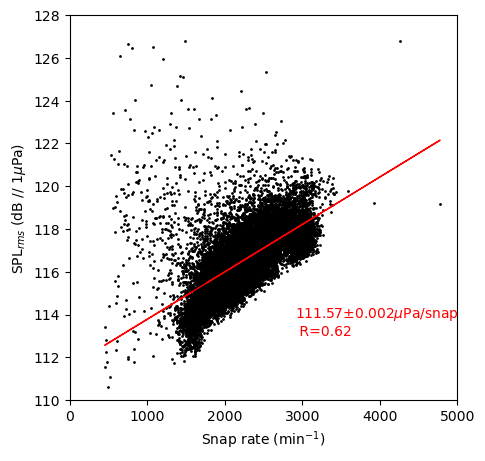

In [9]:
fig, ax = plt.subplots(1, figsize=(5, 5), sharex=True)
plt.rcParams["font.family"] = "DejaVu Sans"
print(ymax)
fsize = 13
alldf = pd.DataFrame()
for filepath in sorted(glob.glob(f'{path}/*csv')):
    
    df = pd.read_csv(filepath)
    ax.scatter(df['Peak'], df['SPLrms'], c='k', marker='o', s=1 )
    alldf = pd.concat([alldf, df])
    print(filepath)
    

alldf = alldf[alldf['Peak']<=ymax]
alldf = alldf[alldf['SPLrms']<=128]
from scipy import stats
res = stats.linregress(alldf['Peak'], alldf['SPLrms'])
plt.plot(alldf['Peak'], res.intercept + res.slope*alldf['Peak'], 'r', lw=1)
print(f"{res.intercept}, {res.slope}, R: {res.rvalue}")

text = f'{round(res.intercept,3)}$\pm${round(res.slope,3)}$\mu$Pa/snap \n R={round(res.rvalue,2)}'
plt.text(ymax-2100,113,text, fontsize=10, color='red')
ax.set_xlim(0,ymax)
ax.set_ylim(110,128)
ax.set_xlabel('Snap rate (min$^{-1}$)')
ax.set_ylabel('SPL$_{rms}$ (dB // 1$\mu$Pa)')
if savefig:
    plt.savefig(f'../Results/Detection_snap/{place}/{place}_{year}{month}_relation.png', dpi=200, bbox_inches='tight')
    plt.savefig(f'../Results/Detection_snap/{place}/{place}_{year}{month}_relation.pdf', dpi=200)

In [300]:
dlight = pd.read_excel(lightpath, header=None, names=['Time', 'Temp', 'Light'], skiprows=100,) 
dlight = dlight[dlight['Light']<10000]

newdf = {'Time':[],
        'peak':[],
        'SPL':[],
        'light':[], 
        'intensity':[]}

for filepath in sorted(glob.glob(f'{path}/*csv')):
    print(filepath)
    df = pd.read_csv(filepath)
    gettime = pd.to_datetime(df['Time'].values[0])
    month = str(gettime.month).zfill(2)
    day = str(gettime.day).zfill(2)
    
    qqq = dlight[dlight['Time'] <= np.datetime64(f'{year}-{month}-{day} 18:00:00')][dlight['Time'] >= np.datetime64(f'{year}-{month}-{day} 05:00:00')]
    meanlight = np.mean(qqq['Light'])
    
    if meanlight >= 500:
        inte = 3

    elif 100 < meanlight < 500:
        inte = 2
    elif 10 < meanlight < 100:
        inte = 1
    elif 10 > meanlight :
        inte = 0
        print(meanlight)
        print()
    for i in range(len(df)):
        time = df['Time'].values[i]
        dlight__ = dlight[dlight['Time']==time]
        if len(dlight__) > 0:
            newdf['Time'].append(time)
            newdf['peak'].append(df['Peak'].values[i])
            newdf['SPL'].append(df['SPLrms'].values[i])
            newdf['light'].append(dlight__['Light'].values[0])
            newdf['intensity'].append(inte)
newdf = pd.DataFrame(newdf)

/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230414.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230415.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230416.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230417.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230418.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230419.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230420.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230421.csv
/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230422.csv
1.6617925736235595

/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230423.csv
1.7408962868117799

/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230424.csv
0.020755441741357235

/Volumes/home/Research/Detection_snap/Taoyuan/230414-230501/detect_230425.csv
0.

2492.2788275116413, -0.1330923889774127, R: -0.4870532992590318


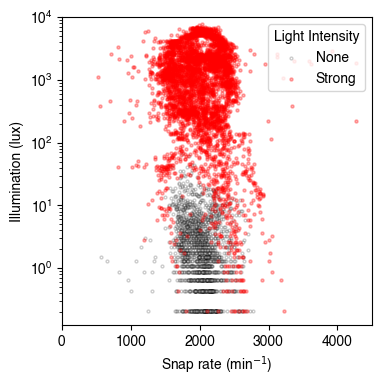

In [299]:
plt.figure(figsize=(4,4))
plt.rc('font', family='Helvetica')
plt.scatter(newdf['peak'][newdf['intensity']==0], newdf['light'][newdf['intensity']==0], s=4, c ='white', alpha=0.2 , label='None', edgecolors='black')
plt.scatter(newdf['peak'][newdf['intensity']==3], newdf['light'][newdf['intensity']==3], s=5, c ='r', alpha=0.3, label='Strong')

# plt.scatter(newdf['light'][newdf['intensity']==2], newdf['peak'][newdf['intensity']==2], s=4, c ='purple', alpha=0.3, label='Medium')
# plt.scatter(newdf['light'][newdf['intensity']==1], newdf['peak'][newdf['intensity']==1], s=3, c ='gold', alpha=0.3, label='Weak')

print(f"{res.intercept}, {res.slope}, R: {res.rvalue}")

# text = f'{round(res.intercept,3)}$\pm${round(res.slope,3)}$\mu$Pa/snap \n R={round(res.rvalue,2)}'
# plt.text(ymax-2000,115,text, fontsize=11, color='red')

plt.xlim(0,4500)
plt.yscale('log')
plt.ylim(0, 10000)
plt.xlabel('Snap rate (min$^{-1}$)')
plt.ylabel('Illumination (lux)')
legend = plt.legend(loc=1,  fancybox = True, fontsize=10)
legend.set_title("Light Intensity")   

2492.2788275116413, -0.1330923889774127, R: -0.4870532992590318


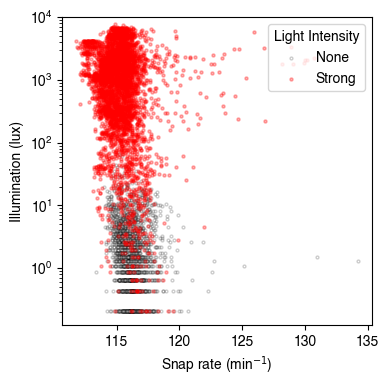

In [302]:
plt.figure(figsize=(4,4))
plt.rc('font', family='Helvetica')
plt.scatter(newdf['SPL'][newdf['intensity']==0], newdf['light'][newdf['intensity']==0], s=4, c ='white', alpha=0.2 , label='None', edgecolors='black')
plt.scatter(newdf['SPL'][newdf['intensity']==3], newdf['light'][newdf['intensity']==3], s=5, c ='r', alpha=0.3, label='Strong')

# plt.scatter(newdf['light'][newdf['intensity']==2], newdf['peak'][newdf['intensity']==2], s=4, c ='purple', alpha=0.3, label='Medium')
# plt.scatter(newdf['light'][newdf['intensity']==1], newdf['peak'][newdf['intensity']==1], s=3, c ='gold', alpha=0.3, label='Weak')

print(f"{res.intercept}, {res.slope}, R: {res.rvalue}")

# text = f'{round(res.intercept,3)}$\pm${round(res.slope,3)}$\mu$Pa/snap \n R={round(res.rvalue,2)}'
# plt.text(ymax-2000,115,text, fontsize=11, color='red')

# plt.xlim(110,130)
plt.yscale('log')
plt.ylim(0, 10000)
plt.xlabel('Snap rate (min$^{-1}$)')
plt.ylabel('Illumination (lux)')
legend = plt.legend(loc=1,  fancybox = True, fontsize=10)
legend.set_title("Light Intensity")   

In [196]:
newdf['light'][newdf['intensity']==3]

0        3420.16
1        3545.60
2        3392.00
3        3472.64
4        3445.76
          ...   
22093       0.00
22094       0.00
22095       0.00
22096       0.00
22097       0.00
Name: light, Length: 5018, dtype: float64

In [141]:
gettime

Timestamp('2023-05-01 00:01:00')